<a href="https://colab.research.google.com/github/linfrick/dip_learners/blob/main/dip_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to drive folder

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/dip_learners_folder

Mounted at /gdrive
/gdrive/My Drive/dip_learners_folder


# Import libraries

In [2]:
seed = 2

# Reduce randomness as much as possible
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)


# Import other libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Useful functions

In [3]:
### Functions to view random images with labels

def view_random_data(X_data, y_data):
  fig = plt.figure(figsize=(8, 8), constrained_layout=True)

  columns = 4
  rows = 5

  index_list = list(range(len(y_data))) #list of all possible image indexes

  for i in range(1, columns*rows +1):
      rnd_index = random.randrange(len(y_data)) #extract random image index ### seed non funziona
      index_list.pop(rnd_index)

      fig.add_subplot(rows, columns, i)
      plt.imshow(X_data[rnd_index].astype('uint8'))
      plt.title(y_data[rnd_index])
  plt.show()

# Load the data and visualize it

In [4]:
dataset = np.load('public_data.npz', allow_pickle=True)

# dataset contains 2 arrays: data and labels
X = dataset['data']
y = dataset['labels']

print(X.shape)
print(y.shape)

(5200, 96, 96, 3)
(5200,)


In [5]:
# Count the occurrences of 'healthy' and 'unhealthy'
healthy_count = np.count_nonzero(y == 'healthy')
unhealthy_count = np.count_nonzero(y == 'unhealthy')

print("Count of 'healthy' labels:", healthy_count)
print("Count of 'unhealthy' labels:", unhealthy_count)

Count of 'healthy' labels: 3199
Count of 'unhealthy' labels: 2001


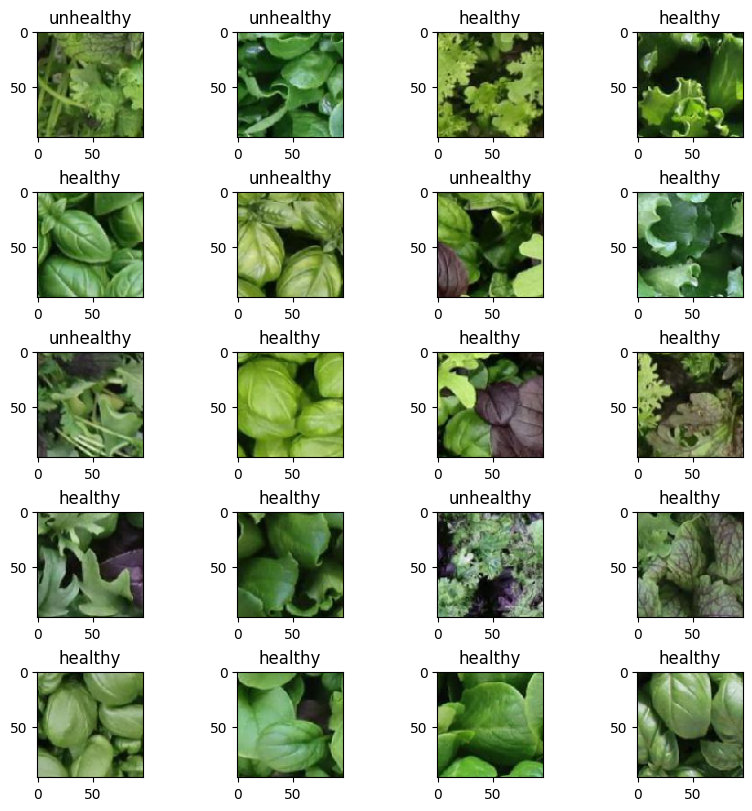

In [6]:
# View some sample images with labels
view_random_data(X,y)

# Remove outliers

In [14]:
## DELETING TROLL IMAGES

# cleaning images from trolls and shreks
shrek = X[58]
troll = X[2150]
shrek_indexes = []
troll_indexes = []
for i in range(0, len(X)):
    shrekDiff = np.mean(np.abs(shrek - X[i]))
    trollDiff = np.mean(np.abs(troll - X[i]))
    if(shrekDiff == 0.0):
        shrek_indexes.append(i)
    elif(trollDiff == 0.0):
        troll_indexes.append(i)

rm_indexes = np.concatenate((shrek_indexes, troll_indexes))

X_clean = np.delete(X, rm_indexes, axis = 0)
y_clean = np.delete(y, rm_indexes, axis = 0)

print('Length of the dataset (images):', len(X_clean))
print('Length of the labels: ', len(y_clean))

## Final result: images + labels

Length of the dataset (images): 5004
Length of the labels:  5004


# Train model with ResNet50

### Prepare data for training

In [15]:
# Change labels to {0,1}
# healthy = 0, unhealthy = 1

y_clean = (np.array(y_clean) == 'unhealthy').astype(int)
print(y_clean)

[0 0 0 ... 0 0 0]


In [16]:
# Split data into train_val and test sets (using seed to reduce randomness of experiments)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_clean, y_clean, random_state=seed, test_size=.20)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test))

### Preprocess data for ResNet50

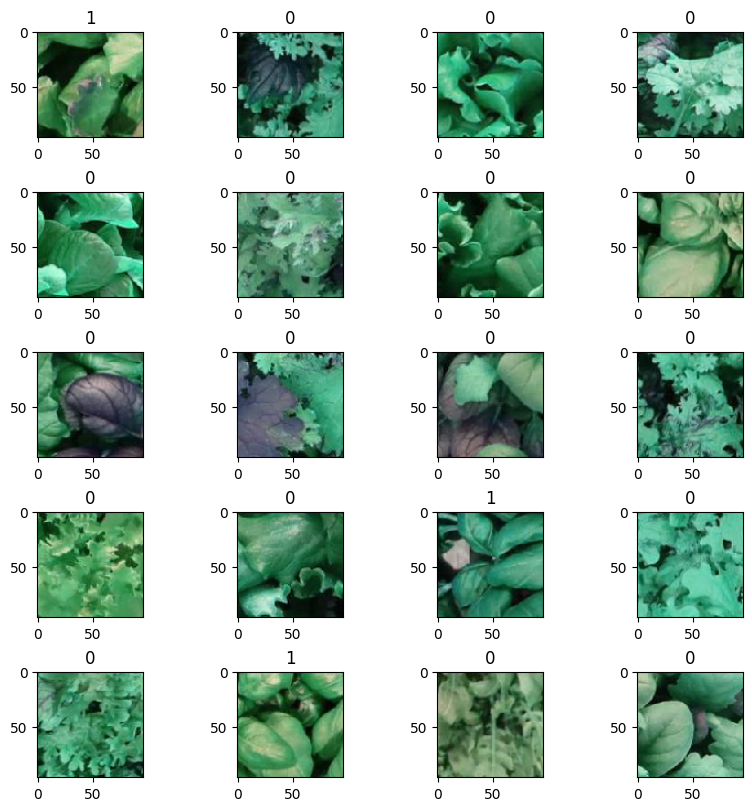

In [18]:
# Convert images from RGB to BGR
X_train = X_train[:,:,:,::-1]
X_val = X_val[:,:,:,::-1]
X_test = X_test[:,:,:,::-1]

view_random_data(X_train,y_train)

In [12]:
# Center pixels of each channel
# (centering done for train, val, test separately to avoid bringing future info into training)

# Compute and store the maximum values for each feature in the training dataset
mean_red = X_train[:,:,:,0].mean()
mean_green = X_train[:,:,:,1].mean()
mean_blue = X_train[:,:,:,2].mean()
print(mean_red)
print(mean_green)
print(mean_blue)


# Compute and store the minimum values for each feature in the training dataset
std_df = X_train.std()
print(std_df)

91.65693
123.83738
69.09749
55.228886


In [ ]:
# X_train_preprocessed = X_train - channel_means
# np.mean(X_train_preprocessed,axis=(0,1,2))

channel_means = np.array([mean_red,mean_green,mean_blue])

X_train_preprocessed = X_train - channel_means # centered dataset
print(np.mean(X_train_preprocessed,axis=(0,1,2))) # mean of centered dataset (almost 0)

X_val_preprocessed = X_val - channel_means # centered dataset
print(np.mean(X_val_preprocessed,axis=(0,1,2))) # mean of centered dataset (almost 0)

X_test_preprocessed = X_test - channel_means # centered dataset
print(np.mean(X_test_preprocessed,axis=(0,1,2))) # mean of centered dataset (almost 0)

[-0.00579308 -0.0320501   0.03530581]
[-0.19445062 -0.32875815 -1.2007502 ]
[ 0.01651957 -0.08154757 -1.357644  ]


In [17]:
### Are the datasets balanced? No, use class weights to balance them during fit
# Count the occurrences of 'healthy' and 'unhealthy'
healthy_count = np.count_nonzero(y_train == 0)
unhealthy_count = np.count_nonzero(y_train == 1)

print("Count of 'healthy' labels:", healthy_count)
print("Count of 'unhealthy' labels:", unhealthy_count)

Count of 'healthy' labels: 1866
Count of 'unhealthy' labels: 1136


In [ ]:
### Create the model
# Allenare base model e continuare training da quello (precomputing the input, uno per train, uno per val, uno per test)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96,3))
base_model.trainable = False

input_layer = tfkl.Input(shape=X_train_preprocessed.shape[1:])
# preprocess = preprocess_input(input_layer) ### Non usare questo, perchè è come se stai usando info dal test set

resnet_model = base_model(input_layer, training=False)

# pooling_layer = tfkl.GlobalAveragePooling2D()(resnet_model)
initializer = tf.keras.initializers.GlorotNormal(seed=seed)

# rendere più graduale riduzione, non puoi andare da 100k a 256 neuroni
x = tfkl.Flatten()(resnet_model)

x = tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=initializer)(x)

x = tfkl.Dropout(0.25)(x)

x = tfkl.Dense(512, activation='leaky_relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tfkl.Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#x = tfkl.Dropout(0.3)(x) # eliminare, non ha senso usarlo alla fine, gli nascondi 30% delle info precedenti

output = tfkl.Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)


model = tfk.Model(inputs=input_layer, outputs=output, name='model')

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Nadam(), metrics=['accuracy', 'Precision', 'Recall'])
# meglio guardare confusion matrix

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 18432)             0         
                                                                 
 dense_42 (Dense)            (None, 1024)              18875392  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_43 (Dense)            (None, 512)               524800    
                                                                 
 dense_44 (Dense)            (None, 64)                32832 

In [ ]:
### Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
)

Epoch 1/100
188/188 [==============================] - 13s 40ms/step - loss: 5.3536 - accuracy: 0.7378 - precision: 0.6911 - recall: 0.5555 - val_loss: 2.6657 - val_accuracy: 0.7952 - val_precision: 0.7752 - val_recall: 0.6260
Epoch 2/100
188/188 [==============================] - 6s 31ms/step - loss: 1.7505 - accuracy: 0.8391 - precision: 0.8149 - recall: 0.7438 - val_loss: 1.2859 - val_accuracy: 0.8062 - val_precision: 0.8327 - val_recall: 0.5935
Epoch 3/100
188/188 [==============================] - 7s 36ms/step - loss: 0.8415 - accuracy: 0.8967 - precision: 0.8810 - recall: 0.8407 - val_loss: 1.0956 - val_accuracy: 0.8022 - val_precision: 0.8767 - val_recall: 0.5393
Epoch 4/100
188/188 [==============================] - 6s 32ms/step - loss: 0.4577 - accuracy: 0.9374 - precision: 0.9317 - recall: 0.9005 - val_loss: 0.9622 - val_accuracy: 0.7602 - val_precision: 0.6418 - val_recall: 0.7913
Epoch 5/100
188/188 [==============================] - 7s 37ms/step - loss: 0.3346 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 27ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.7952
Precision: 0.7966
Recall: 0.7698
F1: 0.7776


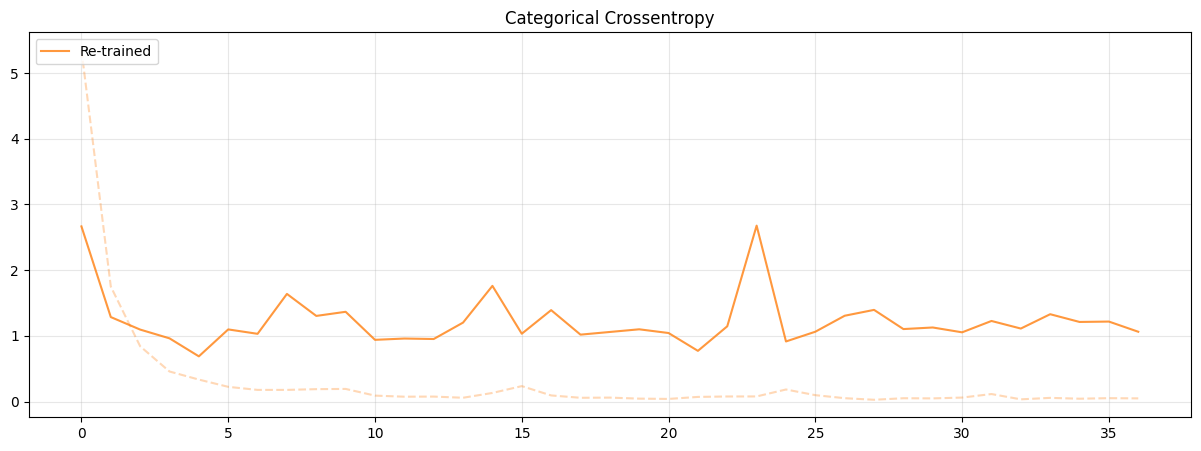

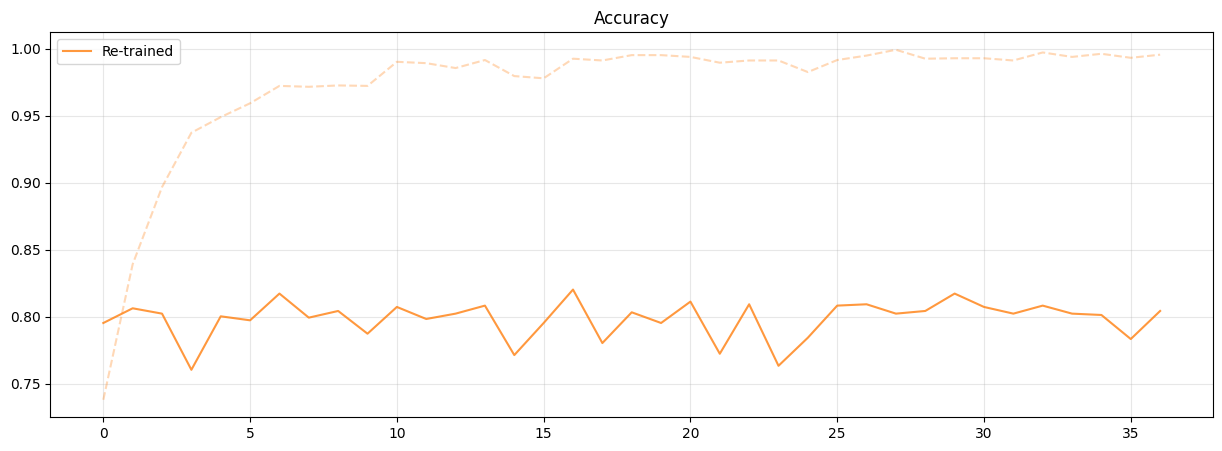

In [ ]:
# Modello con preprocessing + dropout + ridge regularization in 2 livelli

import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

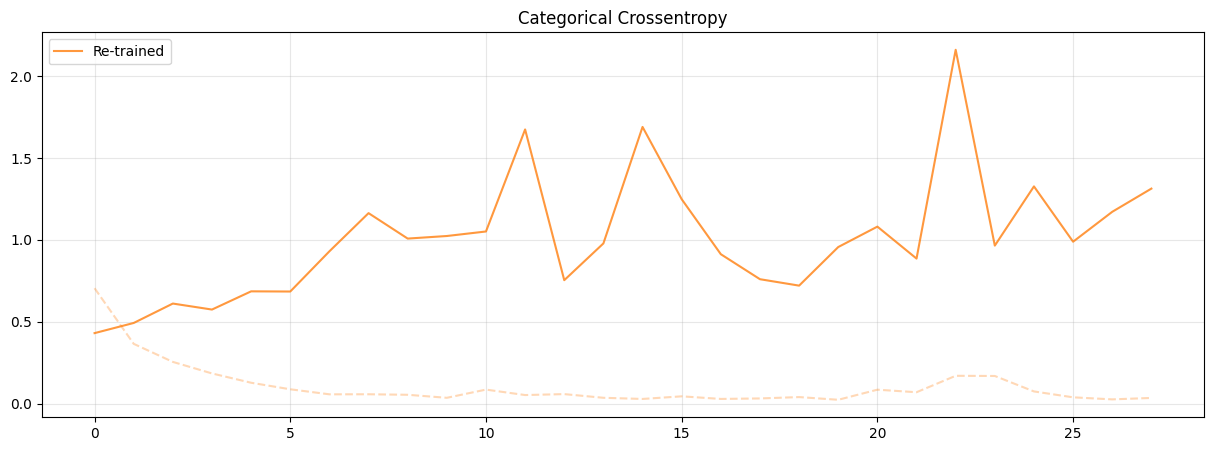

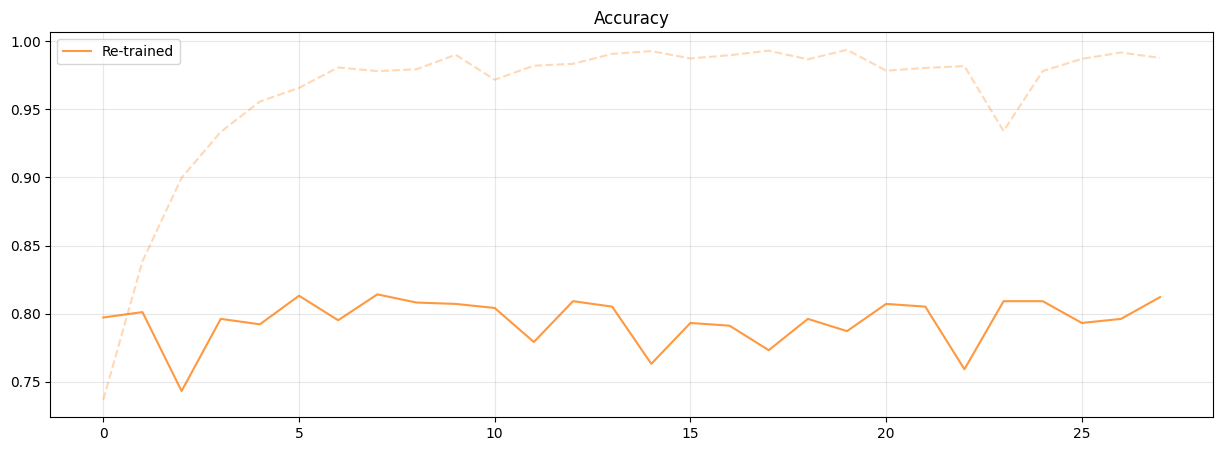

In [ ]:
# Modello con preprocessing + dropout

import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

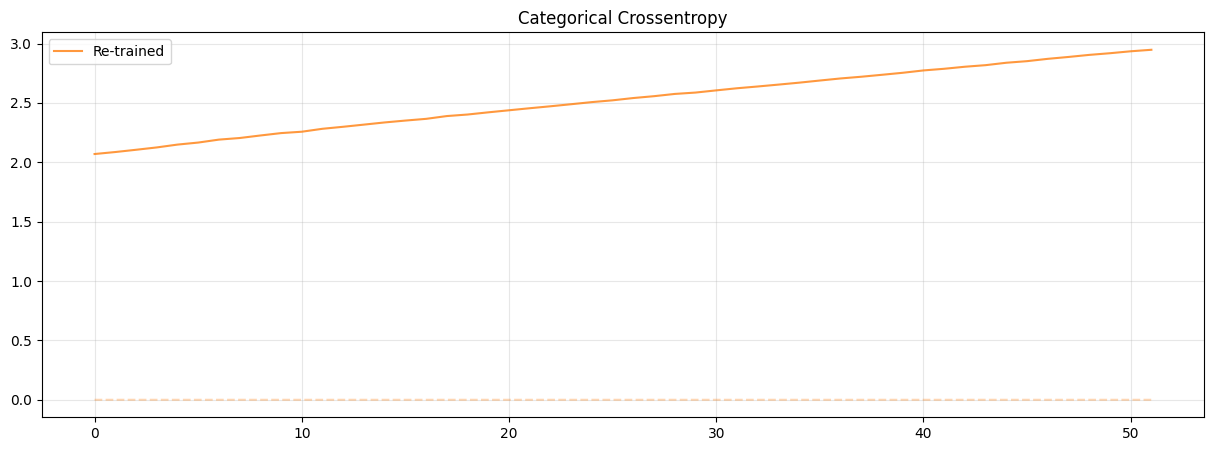

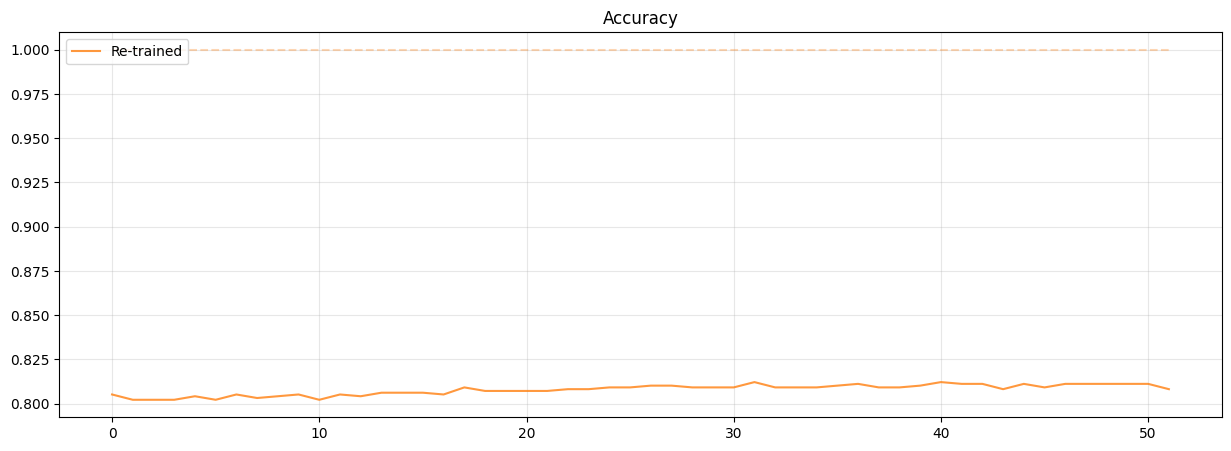

In [ ]:
# Modello con preprocessing

import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

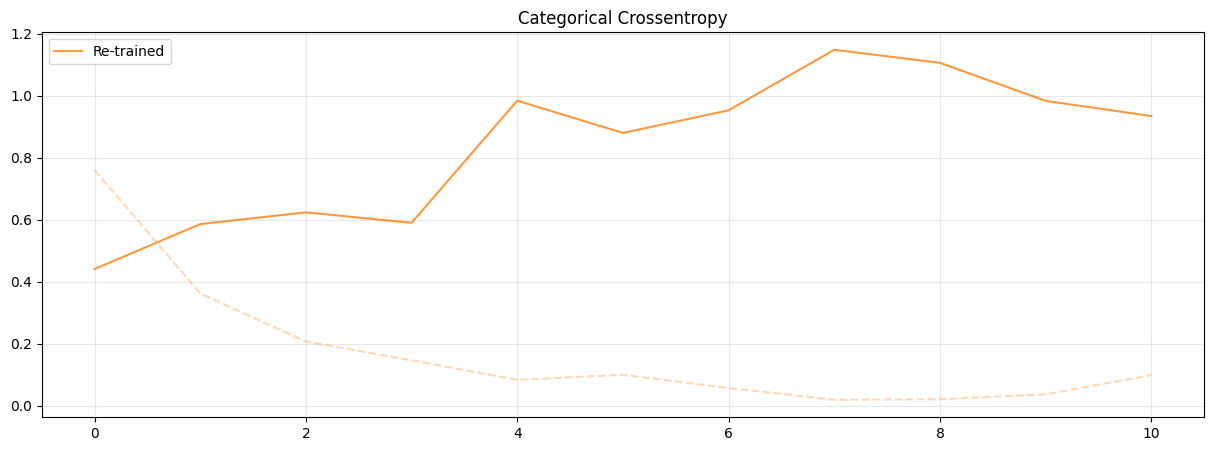

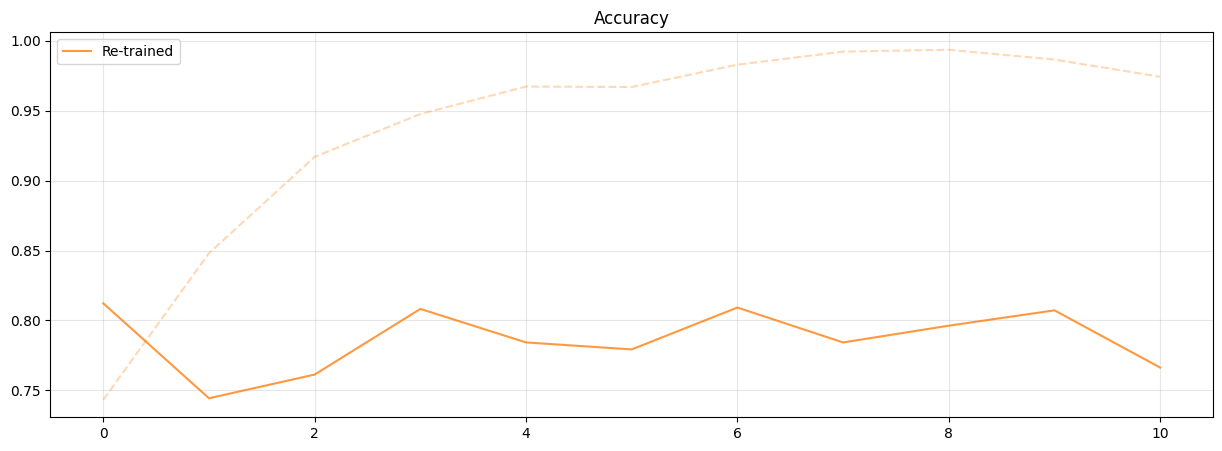

In [ ]:
import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

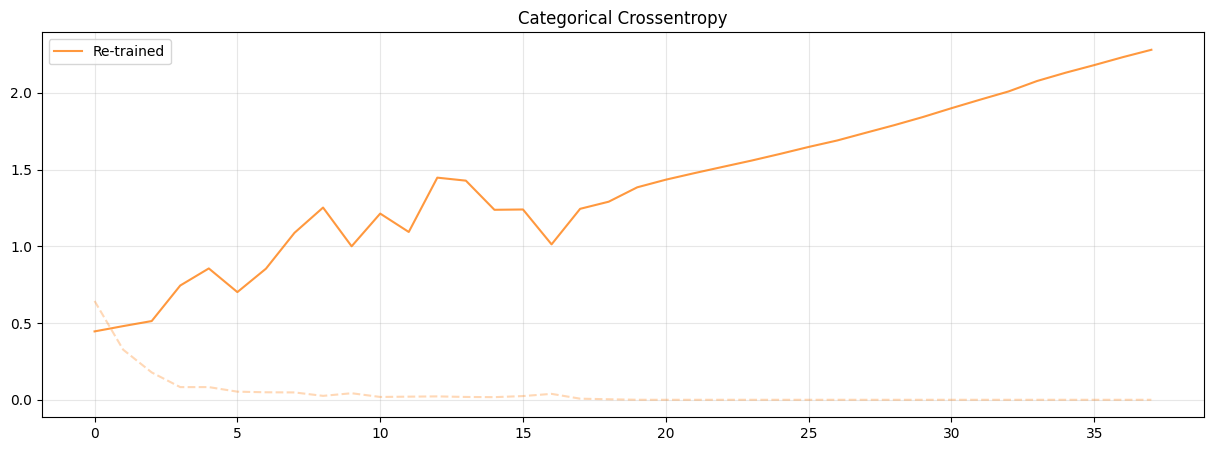

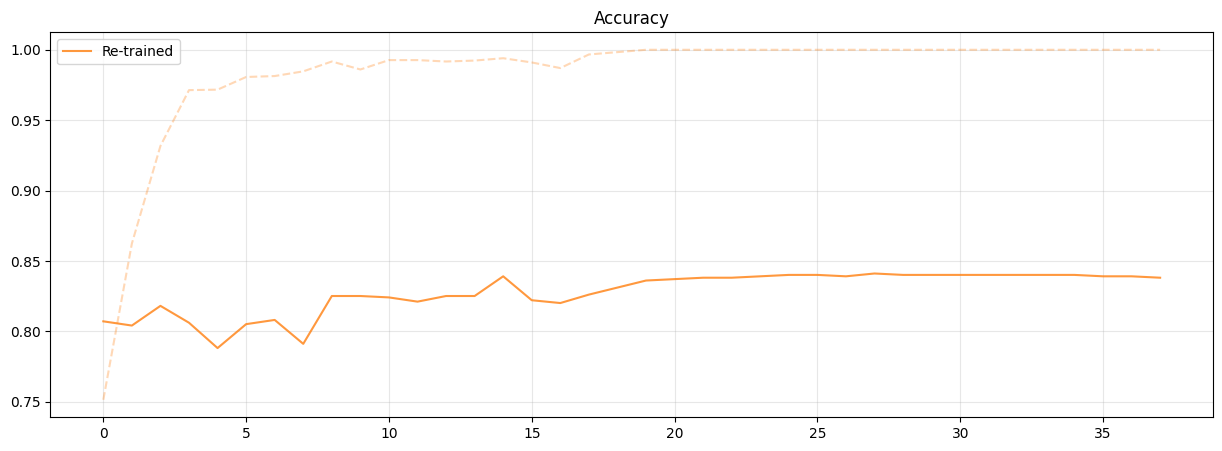

In [ ]:
import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

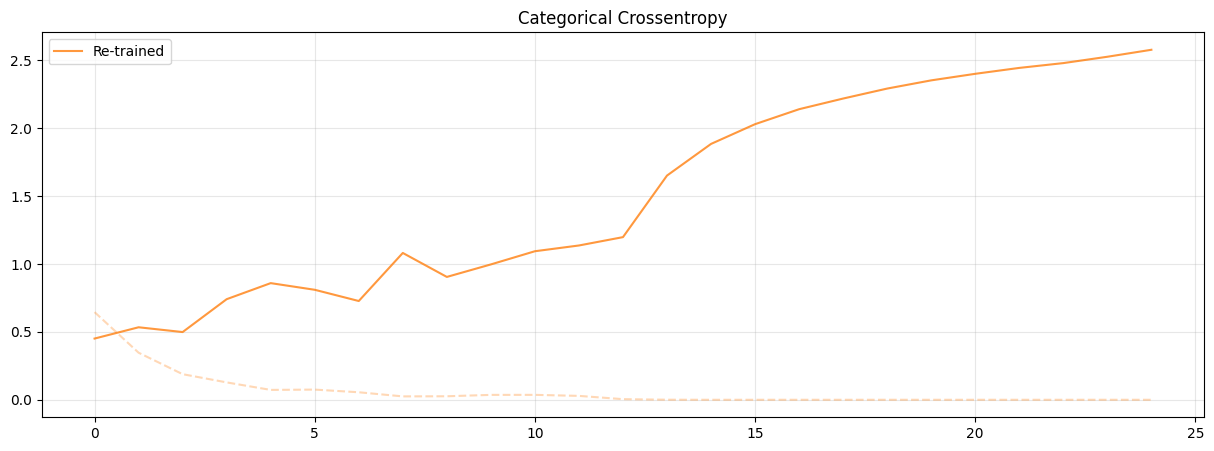

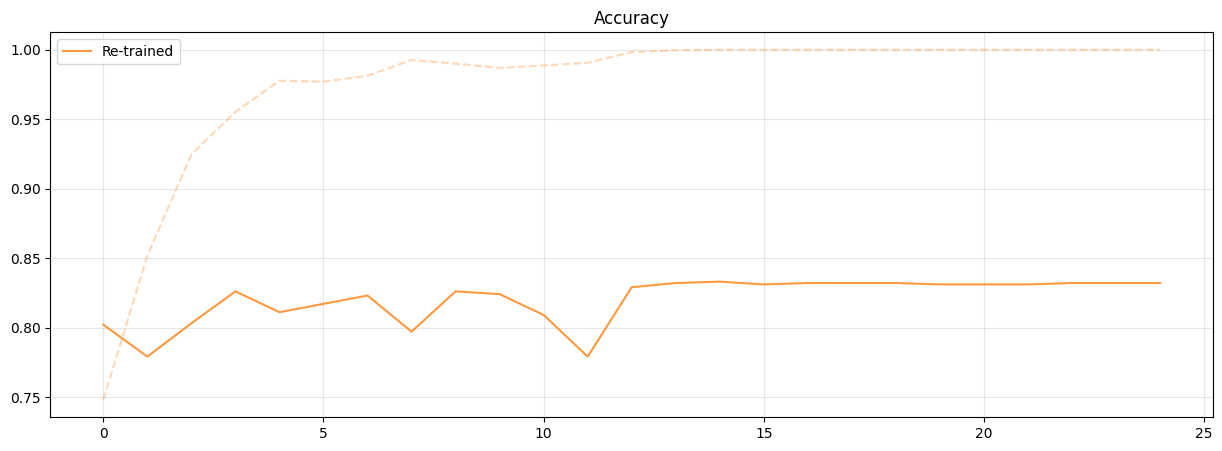

In [ ]:
import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

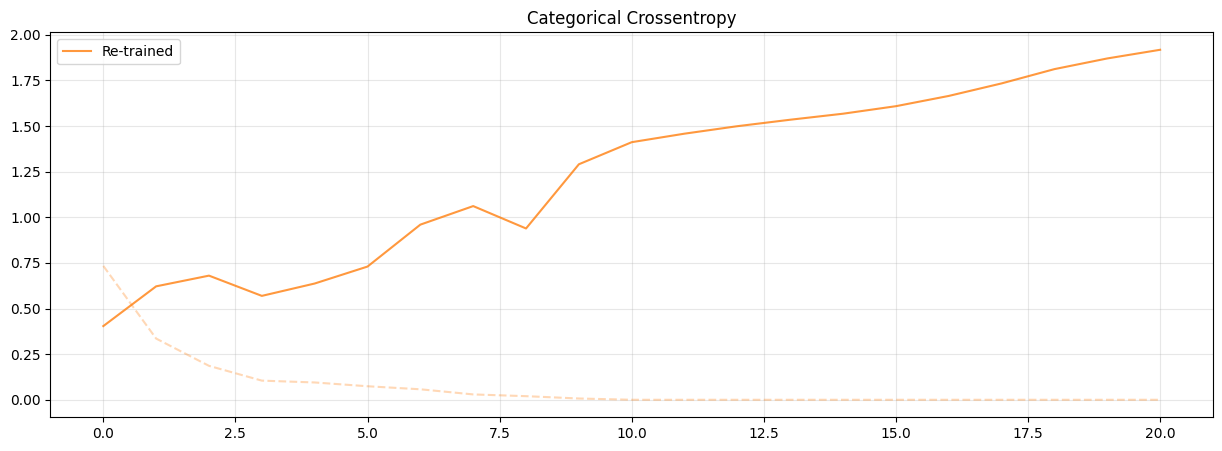

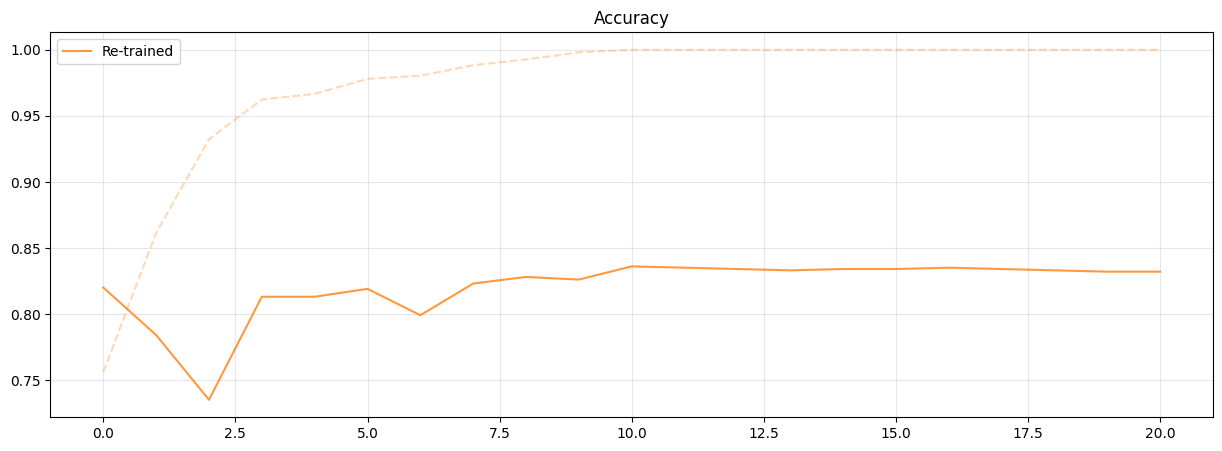

In [ ]:
import matplotlib.pyplot as plt
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Test data augmentation techniques

### Function to build model

In [ ]:
def build_model_with_augmentation(aug_layer, input_shape):
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape)

    # Random augmentation layer
    augmentation = aug_layer(input_layer)

    preprocess = preprocess_input(augmentation)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96,3))
    base_model.trainable = False
    resnet_model = base_model(preprocess, training=False)

    pooling_layer = tfkl.GlobalAveragePooling2D()(resnet_model)

    initializer = tf.keras.initializers.GlorotNormal(seed=seed)
    dense = tfkl.Dense(256, activation='relu', kernel_initializer=initializer)(pooling_layer)

    output = tfkl.Dense(1, activation='sigmoid', kernel_initializer=initializer)(dense)


    model = tfk.Model(inputs=input_layer, outputs=output, name='model')

    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', 'Precision', 'Recall'])

    # Return the model
    return model

### Image flip

In [ ]:
flip_v = tfkl.RandomFlip("vertical")

augmented_model = build_model_with_augmentation(flip_v, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_2  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 11s 37ms/step - loss: 0.5549 - accuracy: 0.7512 - precision: 0.6868 - recall: 0.6294 - val_loss: 0.4433 - val_accuracy: 0.7882 - val_precision: 0.9153 - val_recall: 0.4688
Epoch 2/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3919 - accuracy: 0.8284 - precision: 0.7988 - recall: 0.7306 - val_loss: 0.4101 - val_accuracy: 0.8082 - val_precision: 0.6863 - val_recall: 0.8835
Epoch 3/200
188/188 [==============================] - 5s 25ms/step - loss: 0.3353 - accuracy: 0.8544 - precision: 0.8282 - recall: 0.7764 - val_loss: 0.4053 - val_accuracy: 0.7962 - val_precision: 0.6960 - val_recall: 0.7940
Epoch 4/200
188/188 [==============================] - 5s 25ms/step - loss: 0.3091 - accuracy: 0.8621 - precision: 0.8324 - recall: 0.7958 - val_loss: 0.3859 - val_accuracy: 0.8192 - val_precision: 0.8052 - val_recall: 0.6721
Epoch 5/200
188/188 [==============================] - 5s 26ms/step - loss: 0.2853 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.8292
Precision: 0.8231
Recall: 0.8181
F1: 0.8203


In [ ]:
augmented_model.save('ResNet_group_model')

### Random brightness

In [ ]:
bright = tfkl.RandomBrightness(0.3, value_range=(0,1))

augmented_model = build_model_with_augmentation(bright, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_brightness (RandomB  (None, 96, 96, 3)         0         
 rightness)                                                      
                                                                 
 tf.__operators__.getitem_3  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                             

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 14s 35ms/step - loss: 0.6845 - accuracy: 0.6006 - precision: 0.4103 - recall: 0.1268 - val_loss: 1.3137 - val_accuracy: 0.4156 - val_precision: 0.3583 - val_recall: 0.7398
Epoch 2/200
188/188 [==============================] - 5s 26ms/step - loss: 0.6664 - accuracy: 0.6143 - precision: 0.4599 - recall: 0.1109 - val_loss: 1.9644 - val_accuracy: 0.4006 - val_precision: 0.3655 - val_recall: 0.8509
Epoch 3/200
188/188 [==============================] - 5s 25ms/step - loss: 0.6576 - accuracy: 0.6219 - precision: 0.5024 - recall: 0.0915 - val_loss: 2.4362 - val_accuracy: 0.4046 - val_precision: 0.3709 - val_recall: 0.8835
Epoch 4/200
188/188 [==============================] - 4s 24ms/step - loss: 0.6565 - accuracy: 0.6236 - precision: 0.5075 - recall: 0.1796 - val_loss: 2.6283 - val_accuracy: 0.4046 - val_precision: 0.3726 - val_recall: 0.8997
Epoch 5/200
188/188 [==============================] - 5s 28ms/step - loss: 0.6616 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 23ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.3986
Precision: 0.4299
Recall: 0.4406
F1: 0.3906


### Random zoom

In [ ]:
zoom = tfkl.RandomZoom(0.3) # zoom 30%

augmented_model = build_model_with_augmentation(zoom, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_1  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 12s 38ms/step - loss: 0.5682 - accuracy: 0.7365 - precision: 0.6693 - recall: 0.6004 - val_loss: 0.4661 - val_accuracy: 0.7862 - val_precision: 0.9058 - val_recall: 0.4688
Epoch 2/200
188/188 [==============================] - 5s 25ms/step - loss: 0.4266 - accuracy: 0.7981 - precision: 0.7568 - recall: 0.6875 - val_loss: 0.3723 - val_accuracy: 0.8222 - val_precision: 0.7520 - val_recall: 0.7724
Epoch 3/200
188/188 [==============================] - 5s 26ms/step - loss: 0.3853 - accuracy: 0.8225 - precision: 0.7852 - recall: 0.7306 - val_loss: 0.3894 - val_accuracy: 0.8052 - val_precision: 0.7314 - val_recall: 0.7453
Epoch 4/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3585 - accuracy: 0.8288 - precision: 0.7917 - recall: 0.7430 - val_loss: 0.3934 - val_accuracy: 0.8142 - val_precision: 0.8303 - val_recall: 0.6233
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3442 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 23ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.8422
Precision: 0.8354
Recall: 0.8348
F1: 0.8351


### Random contrast

In [ ]:
contrast = tfkl.RandomContrast(0.3)

augmented_model = build_model_with_augmentation(contrast, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 random_contrast (RandomCon  (None, 96, 96, 3)         0         
 trast)                                                          
                                                                 
 tf.__operators__.getitem_5  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_5 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                             

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 11s 35ms/step - loss: 0.5695 - accuracy: 0.7382 - precision: 0.6692 - recall: 0.6092 - val_loss: 0.4153 - val_accuracy: 0.8022 - val_precision: 0.8608 - val_recall: 0.5528
Epoch 2/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3720 - accuracy: 0.8404 - precision: 0.8102 - recall: 0.7553 - val_loss: 0.3862 - val_accuracy: 0.8112 - val_precision: 0.7446 - val_recall: 0.7425
Epoch 3/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3039 - accuracy: 0.8734 - precision: 0.8559 - recall: 0.8002 - val_loss: 0.3815 - val_accuracy: 0.8232 - val_precision: 0.7609 - val_recall: 0.7588
Epoch 4/200
188/188 [==============================] - 5s 25ms/step - loss: 0.2750 - accuracy: 0.8834 - precision: 0.8606 - recall: 0.8257 - val_loss: 0.3702 - val_accuracy: 0.8292 - val_precision: 0.8214 - val_recall: 0.6856
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.2309 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 25ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


Accuracy: 0.8272
Precision: 0.8195
Recall: 0.8198
F1: 0.8197


### Random flip + random zoom

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem (  (None, 96, 96, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 96, 96, 3)         0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                              

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 25s 43ms/step - loss: 0.5972 - accuracy: 0.7318 - precision: 0.6611 - recall: 0.5977 - val_loss: 0.4461 - val_accuracy: 0.7802 - val_precision: 0.8531 - val_recall: 0.4878
Epoch 2/200
188/188 [==============================] - 5s 25ms/step - loss: 0.4389 - accuracy: 0.7925 - precision: 0.7493 - recall: 0.6787 - val_loss: 0.3802 - val_accuracy: 0.8132 - val_precision: 0.7370 - val_recall: 0.7669
Epoch 3/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4182 - accuracy: 0.8065 - precision: 0.7707 - recall: 0.6954 - val_loss: 0.4097 - val_accuracy: 0.7952 - val_precision: 0.6839 - val_recall: 0.8266
Epoch 4/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3920 - accuracy: 0.8251 - precision: 0.7879 - recall: 0.7359 - val_loss: 0.4040 - val_accuracy: 0.8102 - val_precision: 0.8185 - val_recall: 0.6233
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3739 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 1s 25ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8492
Precision: 0.8449
Recall: 0.8381
F1: 0.841


In [ ]:
# Save the trained model
augmented_model.save('augmented_model.keras')

TypeError: ignored

### Random flip + random contrast

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomContrast(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_7  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_7 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 11s 35ms/step - loss: 0.5704 - accuracy: 0.7412 - precision: 0.6738 - recall: 0.6127 - val_loss: 0.4193 - val_accuracy: 0.7982 - val_precision: 0.8327 - val_recall: 0.5664
Epoch 2/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4047 - accuracy: 0.8245 - precision: 0.7925 - recall: 0.7262 - val_loss: 0.4318 - val_accuracy: 0.7902 - val_precision: 0.6667 - val_recall: 0.8618
Epoch 3/200
188/188 [==============================] - 5s 28ms/step - loss: 0.3612 - accuracy: 0.8378 - precision: 0.8053 - recall: 0.7535 - val_loss: 0.4176 - val_accuracy: 0.8052 - val_precision: 0.6908 - val_recall: 0.8537
Epoch 4/200
188/188 [==============================] - 5s 26ms/step - loss: 0.3302 - accuracy: 0.8551 - precision: 0.8260 - recall: 0.7817 - val_loss: 0.3702 - val_accuracy: 0.8232 - val_precision: 0.8137 - val_recall: 0.6748
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3123 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8382
Precision: 0.8311
Recall: 0.8311
F1: 0.8311


### Contrast + zoom

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomContrast(0.3),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_8  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 10s 37ms/step - loss: 0.5907 - accuracy: 0.7308 - precision: 0.6583 - recall: 0.6004 - val_loss: 0.4241 - val_accuracy: 0.7982 - val_precision: 0.8036 - val_recall: 0.5989
Epoch 2/200
188/188 [==============================] - 5s 27ms/step - loss: 0.4438 - accuracy: 0.7948 - precision: 0.7534 - recall: 0.6805 - val_loss: 0.4313 - val_accuracy: 0.7912 - val_precision: 0.6990 - val_recall: 0.7615
Epoch 3/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4095 - accuracy: 0.8131 - precision: 0.7741 - recall: 0.7148 - val_loss: 0.3987 - val_accuracy: 0.8112 - val_precision: 0.7795 - val_recall: 0.6802
Epoch 4/200
188/188 [==============================] - 6s 30ms/step - loss: 0.3707 - accuracy: 0.8354 - precision: 0.8006 - recall: 0.7526 - val_loss: 0.3906 - val_accuracy: 0.8272 - val_precision: 0.8427 - val_recall: 0.6531
Epoch 5/200
188/188 [==============================] - 5s 27ms/step - loss: 0.3641 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8352
Precision: 0.8272
Recall: 0.8333
F1: 0.8297


### Flip + contrast + zoom

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomContrast(0.3),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_9  (None, 96, 96, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_9 (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0     

In [ ]:
history = augmented_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
188/188 [==============================] - 12s 37ms/step - loss: 0.5833 - accuracy: 0.7278 - precision: 0.6633 - recall: 0.5704 - val_loss: 0.4190 - val_accuracy: 0.8012 - val_precision: 0.8295 - val_recall: 0.5799
Epoch 2/200
188/188 [==============================] - 5s 28ms/step - loss: 0.4460 - accuracy: 0.7931 - precision: 0.7567 - recall: 0.6681 - val_loss: 0.3915 - val_accuracy: 0.8162 - val_precision: 0.7829 - val_recall: 0.6938
Epoch 3/200
188/188 [==============================] - 5s 27ms/step - loss: 0.4215 - accuracy: 0.8065 - precision: 0.7645 - recall: 0.7060 - val_loss: 0.4048 - val_accuracy: 0.8022 - val_precision: 0.7382 - val_recall: 0.7182
Epoch 4/200
188/188 [==============================] - 5s 26ms/step - loss: 0.4080 - accuracy: 0.8098 - precision: 0.7658 - recall: 0.7165 - val_loss: 0.3999 - val_accuracy: 0.8102 - val_precision: 0.8482 - val_recall: 0.5908
Epoch 5/200
188/188 [==============================] - 6s 31ms/step - loss: 0.4003 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (augmented_model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8342
Precision: 0.8263
Recall: 0.8299
F1: 0.8279


#Data augmentation: generate new images

(6004, 96, 96, 3)
(6004,)


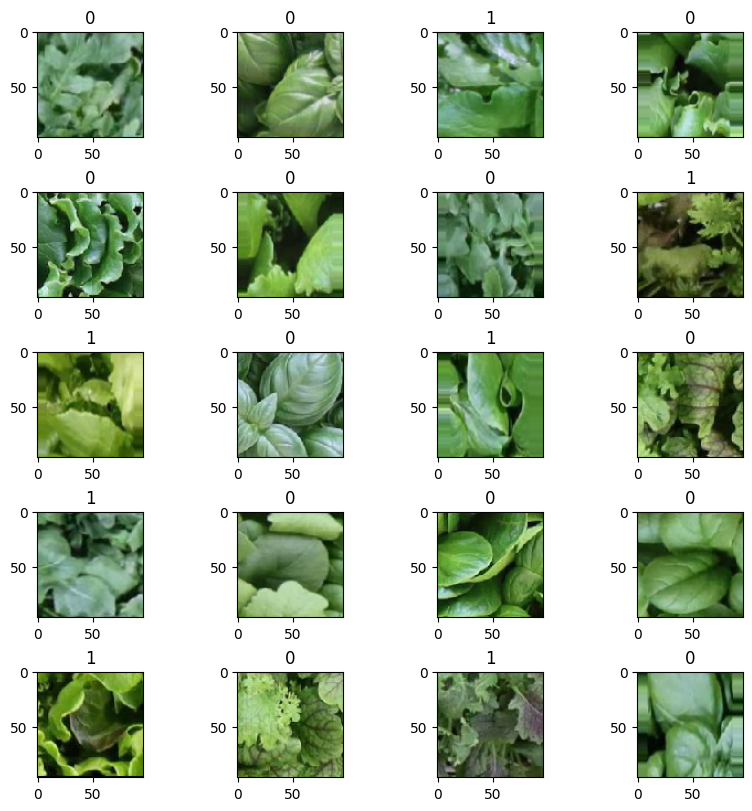

In [ ]:
# Creazione di un oggetto ImageDataGenerator con le tecniche di augmentation
datagen = ImageDataGenerator(
    zoom_range=0.3,
    vertical_flip=True,
    fill_mode='nearest'
)

# Caricamento delle immagini originali e generazione di nuove immagini aumentate
X_train_aug = []
y_train_aug = []

for i in range(len(X_train)):
    original_image = X_train[i]
    image_label = y_train[i]

    X_train_aug.append(original_image)
    y_train_aug.append(image_label)

    #for _ in range(1):  # Genera 1 versione aumentata per ciascuna immagine
    #batch = datagen_zoom.flow(np.expand_dims(original_image, axis=0))
    #augmented_image = batch[0][0]
    #X_train_aug.append(augmented_image)
    #y_train_aug.append(image_label)

    batch = datagen.flow(np.expand_dims(original_image, axis=0))
    augmented_image = batch[0][0]
    X_train_aug.append(augmented_image)
    y_train_aug.append(image_label)



X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print(X_train_aug.shape)
print(y_train_aug.shape)

view_random_data(X_train_aug,y_train_aug)


# Train ResNet50 on augmented train data

In [ ]:
aug_layers = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
  tfkl.RandomZoom(0.3),
])

augmented_model = build_model_with_augmentation(aug_layers, X_train_aug.shape[1:])
augmented_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_1  (None, 96, 96, 3)         0         
 0 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_10 (TFOpLam  (None, 96, 96, 3)         0         
 bda)                                                            
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0     

In [ ]:
history = model.fit(
    X_train_aug,
    y_train_aug,
    batch_size=16,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/200
376/376 [==============================] - 17s 29ms/step - loss: 0.5236 - accuracy: 0.7578 - precision: 0.6974 - recall: 0.6360 - val_loss: 0.4103 - val_accuracy: 0.8152 - val_precision: 0.7754 - val_recall: 0.7019
Epoch 2/200
376/376 [==============================] - 8s 21ms/step - loss: 0.3718 - accuracy: 0.8309 - precision: 0.7991 - recall: 0.7390 - val_loss: 0.3926 - val_accuracy: 0.8192 - val_precision: 0.7901 - val_recall: 0.6938
Epoch 3/200
376/376 [==============================] - 8s 23ms/step - loss: 0.3069 - accuracy: 0.8668 - precision: 0.8442 - recall: 0.7945 - val_loss: 0.3994 - val_accuracy: 0.8292 - val_precision: 0.7861 - val_recall: 0.7371
Epoch 4/200
376/376 [==============================] - 8s 23ms/step - loss: 0.2434 - accuracy: 0.9004 - precision: 0.8777 - recall: 0.8561 - val_loss: 0.4176 - val_accuracy: 0.8332 - val_precision: 0.8117 - val_recall: 0.7127
Epoch 5/200
376/376 [==============================] - 8s 20ms/step - loss: 0.1811 - accuracy: 

In [ ]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

32/32 [==============================] - 2s 26ms/step
Predictions Shape: (1001, 1)


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.7992
Precision: 0.7904
Recall: 0.7902
F1: 0.7903


# Codice di matteo

In [ ]:
nClass1 = 0
for i in range(len(predictions_aug)):
  if predictions_aug[i]<0.5:
    print(predictions_aug[i])
    nClass1=nClass1+1
print(nClass1)

In [ ]:
#del X, X_val, X_train, X_train_val, X_train_aug

# Saving and loading the model

In [ ]:
# Save the trained model
model.save('ResNet_group_model.keras')

# Load the trained model
model = tfk.models.load_model('ResNet_group_model.keras')